## Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [1]:
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
import os
import PIL
import pandas as pd

### Data Reading/Data Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Update paths to dataset directories
path_train = Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
path_test = Path('Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [3]:
# Count number of images in train and test datasets
no_train_images = len(list(path_train.glob('*/*.jpg')))
no_test_images = len(list(path_test.glob('*/*.jpg')))

print("Number of training images:", no_train_images)
print("Number of testing images:", no_test_images)

Number of training images: 2239
Number of testing images: 118


In [4]:
# Count number of images in each class subdirectory
def count_images_by_class(data_path):
    counts = {}
    for each_class_directory in Path(data_path).iterdir():
        if each_class_directory.is_dir():
            counts[each_class_directory.name] = len(list(each_class_directory.glob('*.jpg')))
    return counts

In [5]:
# Plot the distribution of images across classes for train and test datasets
def plot_class_distribution(train_counts_dict, test_counts_dict):
    """
        train_counts (dict): Dictionary containing counts for training data
        test_counts (dict): Dictionary containing counts for testing data
    """
    # Prepare data for plotting
    train_classes = sorted(train_counts_dict.keys())
    train_count = [train_counts_dict[each_class] for each_class in train_classes]

    test_classes = sorted(test_counts_dict.keys())
    test_count = [test_counts_dict[each_class] for each_class in test_classes]

    # Generate distinct colors for each class using a colormap
    train_colors = cm.viridis(np.linspace(0, 1, len(train_classes)))
    test_colors = cm.plasma(np.linspace(0, 1, len(test_classes)))

    # Plot the data
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    fig.suptitle("Class Distribution", fontsize=16)

    # Train dataset plot
    axes[0].bar(train_classes, train_count, color=train_colors)
    axes[0].set_title("Train Dataset")
    axes[0].set_ylabel("Number of Images")
    axes[0].set_xlabel("Class Category")
    axes[0].tick_params(axis='x', rotation=70)
    
    # Add text above bars for train dataset
    for i, value in enumerate(train_count):
        axes[0].text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)


    # Test dataset plot
    axes[1].bar(test_classes, test_count, color=test_colors)
    axes[1].set_title("Test Dataset")
    axes[1].set_xlabel("Class Category")
    axes[1].tick_params(axis='x', rotation=70)

    # Add text above bars for test dataset
    for i, value in enumerate(test_count):
        axes[1].text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)


    # Adjust layout
    plt.tight_layout()
    plt.show()

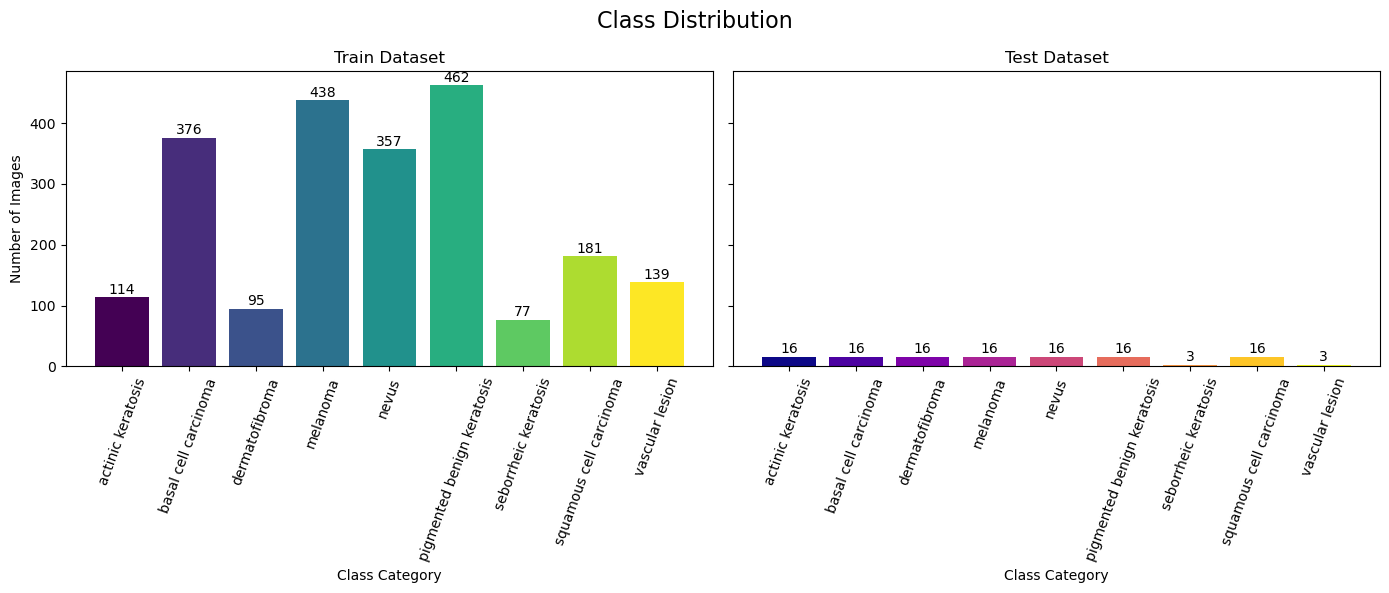

In [6]:
train_counts_dict = count_images_by_class(path_train)
test_counts_dict = count_images_by_class(path_test)
plot_class_distribution(train_counts_dict, test_counts_dict)

<div class="alert alert-block alert-success">
<b>Analysis: </b>

The training dataset shows significant class imbalance, with Pigmented benign keratosis (462) and Melanoma (438) dominating, while Seborrheic keratosis (77) and Dermatofibroma (95) are underrepresented.

<b>Recommendations:</b>

Data Augmentation: Increase samples for minority classes using rotations, flips, and zooming.<br>
Class Weights: Assign higher weights to underrepresented classes during training.<br>
Resampling: Oversample minority classes.<br>
Synthetic Data: Use generative methods like GANs to create additional images for scarce classes.
</div>

### Create a dataset

Define some parameters for the loader:

In [7]:
# Defining Key Paramaters
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
#Allocate 80% of the images for training and 20% for validation.
#Training Dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_train,
    validation_split=0.2,  # Assign 20% of data for validation
    subset="training",     # Define this dataset as the training set
    seed=123,              # Set seed for consistent splitting
    image_size=(img_height, img_width),  # Resize images to the target dimensions
    batch_size=batch_size,  # Number of samples per batch
    label_mode='categorical'  # Labels are represented in categorical format
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [9]:
#Validation Dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_train,
    validation_split=0.2,  # Use the same split for validation data
    subset="validation",   # Define this dataset as the validation set
    seed=123,              # Use the same seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to match the training set
    batch_size=batch_size,  # Keep the batch size consistent
    label_mode='categorical'  # Ensure labels are in categorical format
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [10]:
# Print class names
train_class_names = train_dataset.class_names
print("Classes in dataset:", train_class_names)

Classes in dataset: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Dataset visualisation

2024-12-18 21:42:24.627379: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


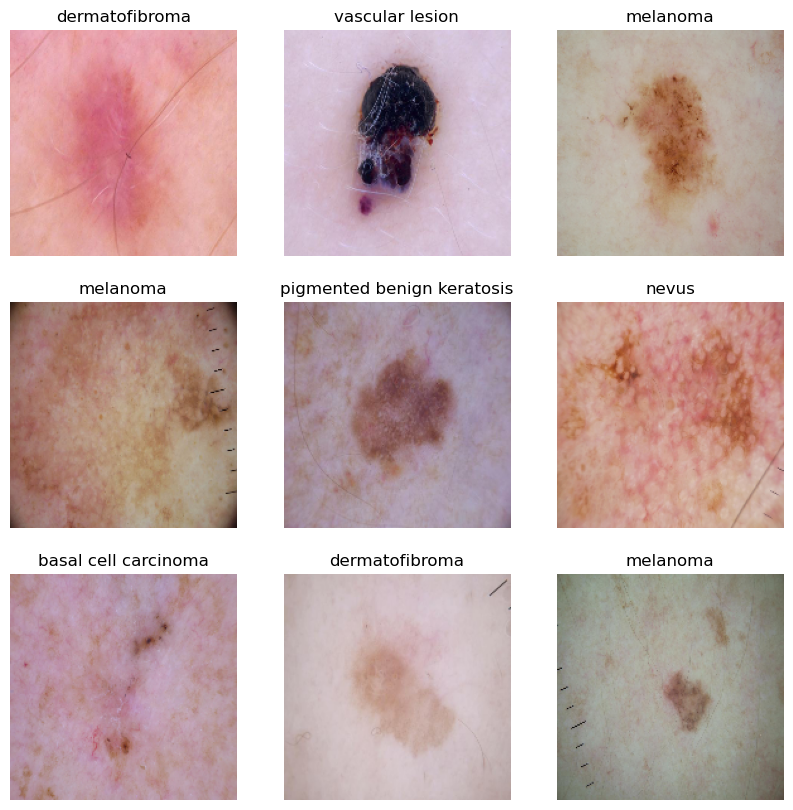

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_class_names[tf.argmax(labels[i])])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
# Automatically tune performance with AUTOTUNE
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Optimize the training dataset
train_dataset = (
    train_dataset
    .cache()  # Store data in memory for faster access
    .shuffle(1000)  # Randomize the data order
    .prefetch(buffer_size=AUTOTUNE)  # Load data ahead of time to improve speed
)

# Optimize the validation dataset
validation_dataset = (
    validation_dataset
    .cache()  # Store data in memory for faster validation
    .prefetch(buffer_size=AUTOTUNE)  # Load data ahead of time
)

## Initial Model

### Create the model

In [13]:
# Define the CNN model
model = Sequential([
    # Rescale pixel values
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # dropout for regularization
    Dense(len(train_class_names), activation='softmax')  # Output layer
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the Model with appropriate optimiser and loss function

In [14]:
# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [15]:
epochs = 20
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 76s 410ms/step - accuracy: 0.1799 - loss: 2.2050 - val_accuracy: 0.3682 - val_loss: 1.7006
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 73s 430ms/step - accuracy: 0.3330 - loss: 1.7227 - val_accuracy: 0.4684 - val_loss: 1.4292
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 444ms/step - accuracy: 0.4303 - loss: 1.5041 - val_accuracy: 0.4900 - val_loss: 1.3277
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 78s 464ms/step - accuracy: 0.4870 - loss: 1.3463 - val_accuracy: 0.5316 - val_loss: 1.2585
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 77s 457ms/step - accuracy: 0.5206 - loss: 1.2632 - val_accuracy: 0.6021 - val_loss: 1.1130
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 469ms/step - accuracy: 0.5596 - loss: 1.1767 - val_accuracy: 0.6407 - val_loss: 1.0051
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 80s 474ms/step - accuracy: 0.6126 - loss: 1.0224 - val_accuracy: 0.6800 - val_loss: 0.8896
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 92s 544ms/step - accuracy: 0.6327 - loss: 0

### Visualizing training results

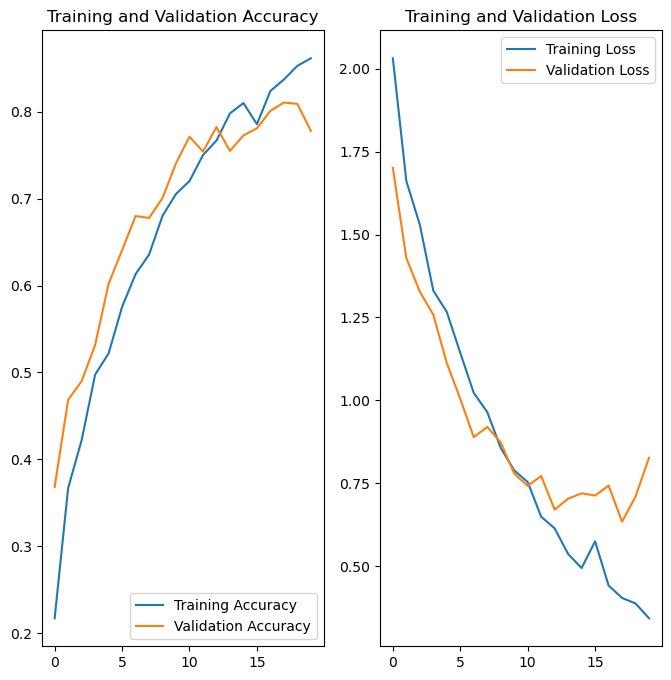

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

<div class="alert alert-block alert-success">


1. `Overfitting:` As training continues beyond that optimal point, the validation metrics stop improving and start to worsen, while training metrics continue to improve. This pattern is a sign of overfitting.


2. `Diverging Loss:` Training Loss consistently decreases, while the Validation Loss does not follow the same trend.
</div>

## Model with Augmentation

In [17]:
# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2)
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
train_class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

2024-12-18 22:13:37.004715: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


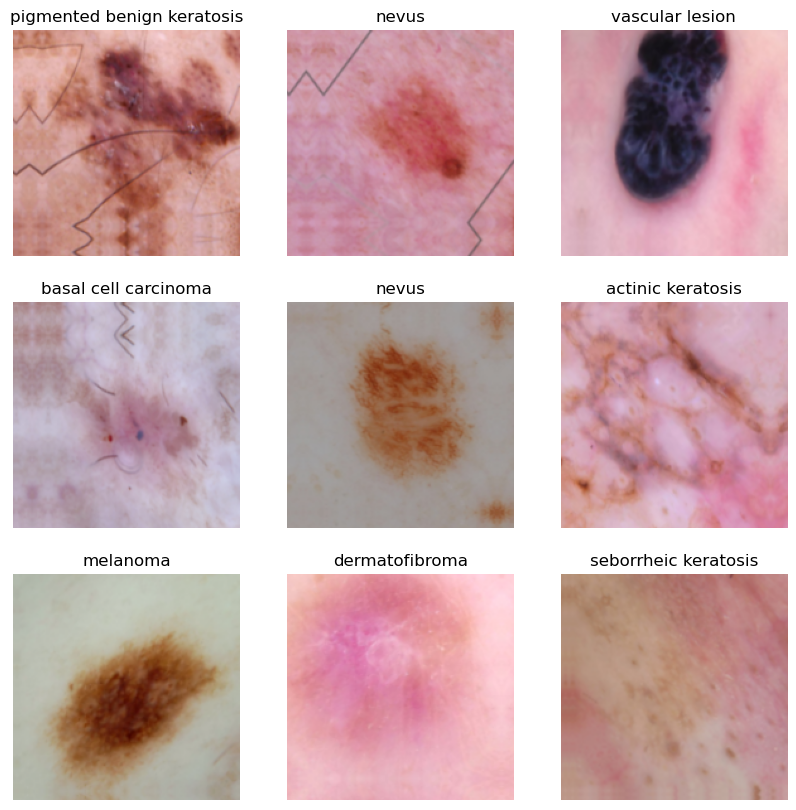

In [19]:
# Visualize the Augmented Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    label_array = labels[i].numpy()
    label_index = np.argmax(label_array)
    
    augmented_image = data_augmentation(tf.expand_dims(images[i], 0))
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0].numpy().astype("uint8"))
    plt.title(train_class_names[label_index])
    plt.axis("off")


In [20]:
model_with_augmentation = Sequential([
    # Data augmentation
    data_augmentation,
    
    # Rescale pixel values
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # dropout for regularization
    Dense(len(train_class_names), activation='softmax')  # Output layer
])




/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the Model with Augmentation (using appropriate optimiser and loss function)

In [21]:
# Compile the model
model_with_augmentation.compile(optimizer='adam',
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

# Display the model summary
model_with_augmentation.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the Model with Augmentation

In [22]:
epochs = 20
history = model_with_augmentation.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 106s 622ms/step - accuracy: 0.1948 - loss: 2.1842 - val_accuracy: 0.4172 - val_loss: 1.6562
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 591ms/step - accuracy: 0.3685 - loss: 1.6921 - val_accuracy: 0.4246 - val_loss: 1.5398
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 99s 586ms/step - accuracy: 0.4082 - loss: 1.5686 - val_accuracy: 0.4350 - val_loss: 1.4898
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 593ms/step - accuracy: 0.4193 - loss: 1.5146 - val_accuracy: 0.4425 - val_loss: 1.4617
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 594ms/step - accuracy: 0.4447 - loss: 1.5003 - val_accuracy: 0.4462 - val_loss: 1.4122
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 578ms/step - accuracy: 0.4474 - loss: 1.4513 - val_accuracy: 0.4558 - val_loss: 1.3545
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 578ms/step - accuracy: 0.4655 - loss: 1.3809 - val_accuracy: 0.4707 - val_loss: 1.3413
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 96s 570ms/step - accuracy: 0.4483 - los

### Visualizing the results

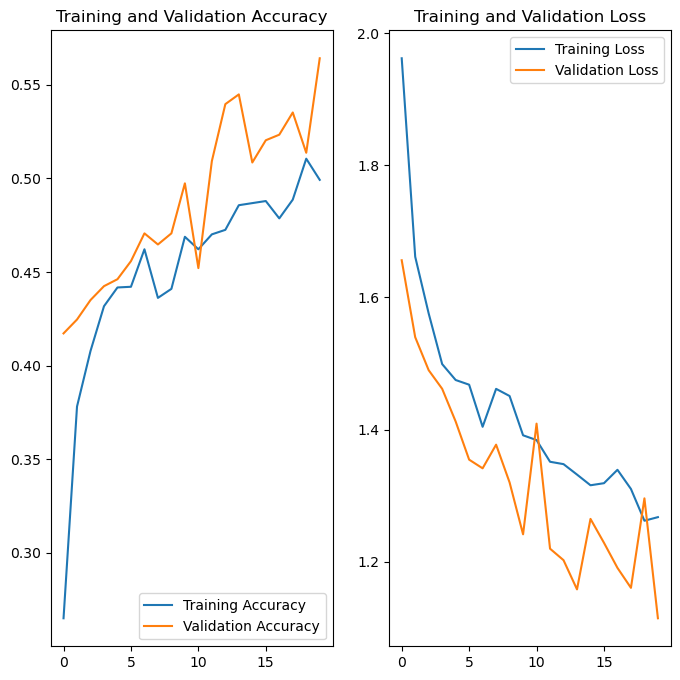

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

<div class="alert alert-block alert-success">
With Data Augmentation, 

1. `No Overfitting / Improvement compared to previous Model` : `validation accuracy` often matches or even tops the `training accuracy`, and both stay fairly close. This indicates that it’s not heavily overfitting, unlike the previous initial base model, which clearly did. 

2. `Low Accuracy`: Still, the model isn’t achieving very high accuracy yet, and performance remains somewhat inconsistent. More tuning, epochs, or architectural changes may help. Compared to the base model, where training accuracy soared while validation stagnated or worsened, the data augmentation has helped bring these metrics into closer alignment. Though the absolute accuracy hasn’t skyrocketed, the improved balance suggests better generalization and less risk of overfitting.
</div>

## Class distribution


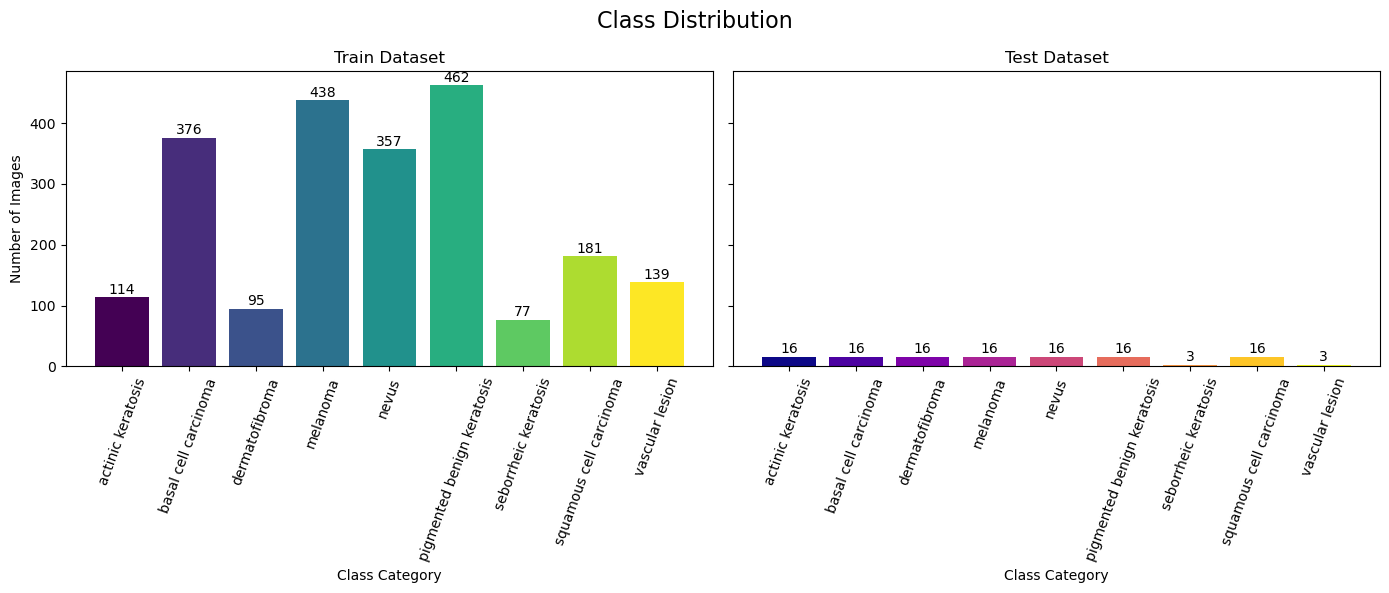

In [24]:
plot_class_distribution(train_counts_dict, test_counts_dict)

<div class="alert alert-block alert-success">
<b>Analysis: </b>

The training dataset shows significant class imbalance, with Pigmented benign keratosis (462) and Melanoma (438) dominating, while Seborrheic keratosis (77) and Dermatofibroma (95) are underrepresented.
</div>

1. <b>Which class has the least number of samples?<b> <br>
Ans) `Seborrheic keratosis` has least number of samples with only 77 samples.


2. <b>Which classes dominate the data in terms of the proportionate number of samples?<b> <br>
Ans) `Pigmented benign keratosis (462), Melanoma (438), basal cell carcinoma (376) and nevus (357)` together dominates data with 72.93% samples.

## Rectifying the Class Imbalance using Augmentor library

In [25]:
#Install Augmentor
!pip install Augmentor

In [40]:
import Augmentor

for i in train_class_names:
    p = Augmentor.Pipeline(path_train / i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)

    # Adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x174C83210>: 100%|██████████| 500/500 [00:02<00:00, 199.53 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x174CC68D0>: 100%|██████████| 500/500 [00:02<00:00, 214.60 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x16A0DF3D0>: 100%|██████████| 500/500 [00:02<00:00, 197.97 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x163B12750>: 100%|██████████| 500/500 [00:11<00:00, 42.89 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x1734B4810>: 100%|██████████| 500/500 [00:11<00:00, 44.07 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x163AA8E50>: 100%|██████████| 500/500 [00:02<00:00, 193.77 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x16A0D5410>: 100%|██████████| 500/500 [00:05<00:00, 89.78 Samples/s]                   


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31C307AD0>: 100%|██████████| 500/500 [00:02<00:00, 195.31 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x31C168090>: 100%|██████████| 500/500 [00:02<00:00, 187.08 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [41]:
image_count_train = len(list(path_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


#### Lets see the distribution of augmented data after adding new images to the original training data.

In [42]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(path_train, '*','output', '*.jpg'))]
path_list_new

['Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010555.jpg_12b05826-8154-4f71-adf8-c4da38b0ffe3.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009913.jpg_17b8dd05-b38b-4f65-955e-3a9120b167e6.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010784.jpg_cf4803f1-84ec-47e1-9090-f938fc240998.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010049.jpg_b2b438d9-262a-4c5f-95ab-9566fb75ce21.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000519.jpg_4f97fa3d-bb09-4326-ab4e-22af4f8f88ee.jpg',
 'Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010039.jpg_d1702a7b-5a7d-499b-85b3-93f0fb930926.jpg',
 'Skin cancer IS

In [43]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(path_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [45]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [46]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [47]:
new_df['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

<b>So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.</b>

## Final Model (after Augmentor) 

### Create Dataset (After Augmentor)

In [48]:
#Allocate 80% of the images for training and 20% for validation.
#Training Dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_train,
    validation_split=0.2,  # Assign 20% of data for validation
    subset="training",     # Define this dataset as the training set
    seed=123,              # Set seed for consistent splitting
    image_size=(img_height, img_width),  # Resize images to the target dimensions
    batch_size=batch_size,  # Number of samples per batch
    label_mode='categorical'  # Labels are represented in categorical format
)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [49]:
#Validation Dataset
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory=path_train,
    validation_split=0.2,  # Use the same split for validation data
    subset="validation",   # Define this dataset as the validation set
    seed=123,              # Use the same seed for reproducibility
    image_size=(img_height, img_width),  # Resize images to match the training set
    batch_size=batch_size,  # Keep the batch size consistent
    label_mode='categorical'  # Ensure labels are in categorical format
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create Model (After Augmentor)

In [50]:
# Define the CNN model
model_after_augmentor = Sequential([
    # Rescale pixel values
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Convolutional Layer 1
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Convolutional Layer 2
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Convolutional Layer 3
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten and Dense Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # dropout for regularization
    Dense(len(train_class_names), activation='softmax')  # Output layer
])

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile Model with appropriate Optimizer and Loss Function (After Augmentor)

In [51]:
# Compile the model
model_after_augmentor.compile(optimizer='adam',
                                 loss='categorical_crossentropy',
                                 metrics=['accuracy'])

# Display the model summary
model_after_augmentor.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,929,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,024,393 (30.61 MB)

 Trainable params: 8,024,393 (30.61 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model (After Augmentor)

In [52]:
epochs = 30
history = model_after_augmentor.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 79s 464ms/step - accuracy: 0.1755 - loss: 2.2184 - val_accuracy: 0.3304 - val_loss: 1.8611
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 84s 494ms/step - accuracy: 0.3432 - loss: 1.7301 - val_accuracy: 0.4603 - val_loss: 1.4750
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 86s 506ms/step - accuracy: 0.4439 - loss: 1.4751 - val_accuracy: 0.4670 - val_loss: 1.3778
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 87s 517ms/step - accuracy: 0.4606 - loss: 1.3946 - val_accuracy: 0.5212 - val_loss: 1.2406
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 89s 527ms/step - accuracy: 0.5070 - loss: 1.2986 - val_accuracy: 0.5353 - val_loss: 1.2017
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 100s 594ms/step - accuracy: 0.5472 - loss: 1.2065 - val_accuracy: 0.5716 - val_loss: 1.1051
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 582ms/step - accuracy: 0.5628 - loss: 1.1372 - val_accuracy: 0.6288 - val_loss: 0.9796
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 98s 582ms/step - accuracy: 0.5977 - loss: 

### Visualizing the results (After Augmentor)

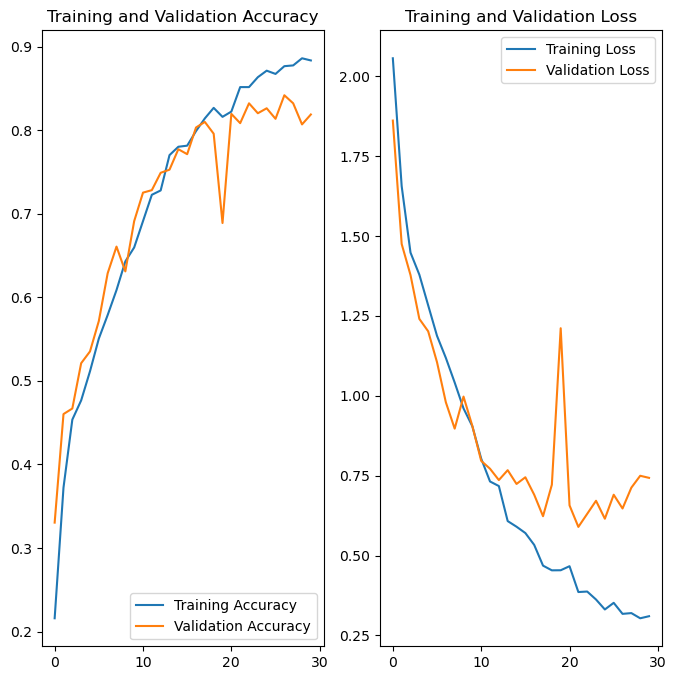

In [53]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings

<div class="alert alert-block alert-success">
With this third model using Augmentor, the training and validation accuracy lines remain close, and both show steady improvement. The validation accuracy doesn’t lag far behind the training accuracy, suggesting less overfitting than we saw with the base model. Compared to Model 1 and the initial augmented model, this approach shows more balanced performance. The loss curves also indicate improvement, though some fluctuations remain. It’s not a perfect solution, as accuracy could still improve and the curves could smooth out further, but overall, the <b>use of Augmentor appears to have helped reduce overfitting and move toward more generalizable learning</b>.
</div>

## Model Predictions on Test Dataset

Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0025427.jpg
Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/seborrheic keratosis/ISIC_0010803.jpg
Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0025605.jpg
Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/basal cell carcinoma/ISIC_0024403.jpg
Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000049.jpg
Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/dermatofibroma/ISIC_0024994.jpg
Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/dermatofibroma/ISIC_0011410.jpg
Selected Image Path: Skin cancer ISIC The International Skin Imaging Collaboration/Test/pigmented benign keratosis/ISIC_0024408.jpg
Selected Image P

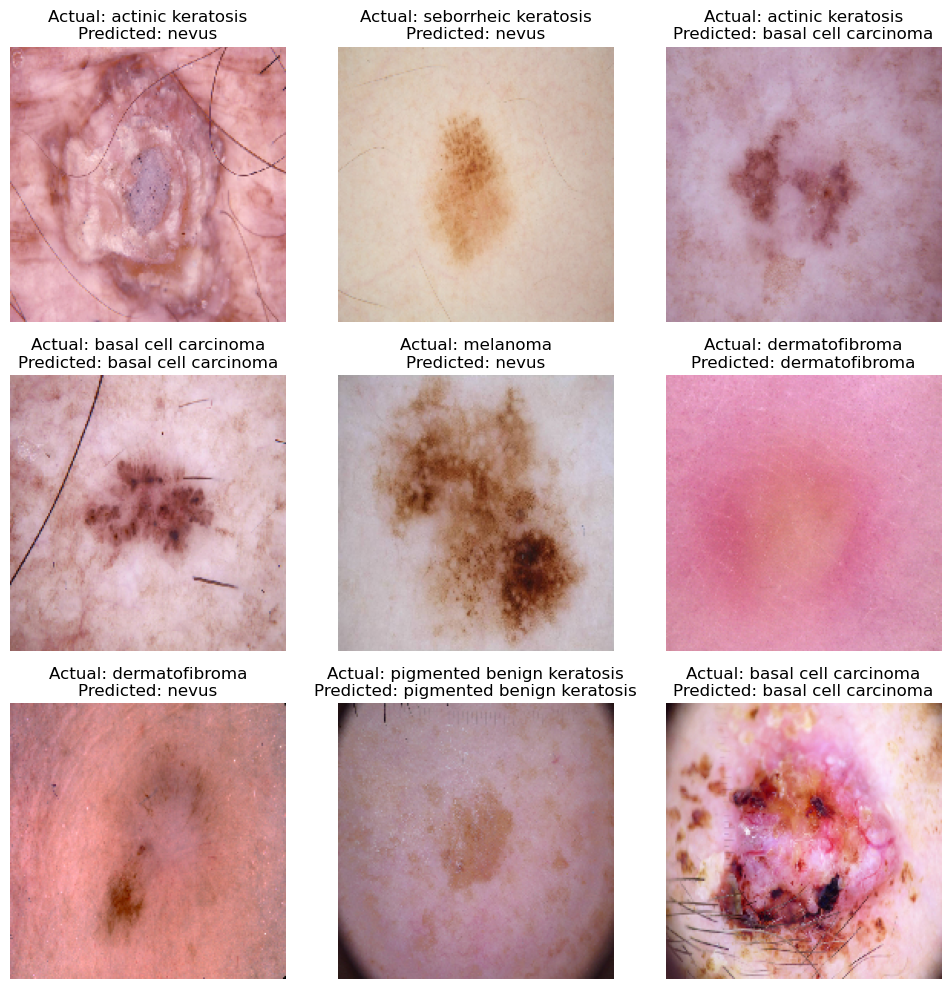

In [55]:
import random
# Retrieve all image file paths from the test dataset
test_image_paths = os.path.join(path_test, '*', '*')  # Path to all test images
all_test_images = glob(test_image_paths)

# Configure the grid to display 9 randomly selected images
plt.figure(figsize=(10, 10))  # Set figure dimensions
num_images_to_display = 9  # Number of images to display

for image_index in range(num_images_to_display):
    # Randomly select an image path from the test dataset
    selected_image_path = random.choice(all_test_images)
    print(f"Selected Image Path: {selected_image_path}")

    # Load the selected image and resize it to the required input dimensions
    loaded_image = keras.preprocessing.image.load_img(
        selected_image_path, target_size=(180, 180, 3)
    )

    # Convert the image to an array and expand dimensions to create a batch
    image_array = keras.preprocessing.image.img_to_array(loaded_image)
    image_batch = np.expand_dims(image_array, axis=0)

    # Predict the class of the image using the trained model
    prediction_probabilities = model_after_augmentor.predict(image_batch, verbose=0)
    predicted_class_index = np.argmax(prediction_probabilities)
    predicted_class_label = train_class_names[predicted_class_index]

    # Extract the actual class label from the image path
    actual_class_label = os.path.basename(os.path.dirname(selected_image_path))

    # Display the image with predicted and actual labels
    plt.subplot(3, 3, image_index + 1)
    plt.imshow(loaded_image)
    plt.title(f"Actual: {actual_class_label}\nPredicted: {predicted_class_label}")
    plt.axis('off')

# Adjust the layout and display the figure
plt.tight_layout()
plt.show()